Get the stock price for Microsoft from yahoo finance and apply the moving over cross over
 trading strategy to the period from the year of 2020 to 2023

In [752]:
from datetime import datetime
import pandas as pd

In [753]:
'''Convert date to the epoch time'''
def date_to_epoch(date):
    return int(date.timestamp())

In [754]:
'''Get the public stock price data for a given ticker'''
def get_stock_price(ticker:str, start_date :datetime = None, end_date :datetime = None) -> pd.DataFrame:
    if not start_date:
        start_date = datetime(2020, 11, 1)
    if not end_date:
        end_date = datetime.now()

    url = f"https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={date_to_epoch(start_date)}&period2={date_to_epoch(end_date)}&interval=1d&events=history&includeAdjustedClose=true"
    df = pd.read_csv(url)
    df = df.set_index("Date")
    df.index = pd.to_datetime(df.index)
    return df
        

In [755]:
df_data = get_stock_price("MSFT")

In [756]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 634 entries, 2020-11-02 to 2023-05-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       634 non-null    float64
 1   High       634 non-null    float64
 2   Low        634 non-null    float64
 3   Close      634 non-null    float64
 4   Adj Close  634 non-null    float64
 5   Volume     634 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 34.7 KB


In [757]:
'''Inspect the data'''
df_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-02,204.289993,205.279999,200.119995,202.330002,197.771011,30842200
2020-11-03,203.889999,208.119995,203.119995,206.429993,201.778625,27512000
2020-11-04,214.020004,218.320007,212.419998,216.389999,211.514206,42311800
2020-11-05,222.039993,224.119995,221.149994,223.289993,218.258713,36080100
2020-11-06,222.259995,224.360001,218.029999,223.720001,218.679047,25231900


In [758]:
df_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-04,306.239990,307.760010,303.399994,305.410004,305.410004,22519900
2023-05-05,305.720001,311.970001,304.269989,310.649994,310.649994,28181200
2023-05-08,310.130005,310.200012,306.089996,308.649994,308.649994,21318600
2023-05-09,308.000000,310.040009,306.309998,307.000000,307.000000,21340800
2023-05-10,308.619995,313.000000,307.670013,312.309998,312.309998,30058700


In [759]:
df_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,634.000000,634.000000,634.000000,634.000000,634.000000,6.340000e+02
mean,267.822839,270.672255,264.928359,267.936514,265.121510,2.891769e+07
std,33.011098,33.069274,32.644641,32.925652,32.795579,1.029128e+07
min,203.889999,205.279999,200.119995,202.330002,197.771011,9.200800e+06
25%,242.477501,244.692497,240.227493,242.375004,240.139901,2.241728e+07
50%,261.755005,265.880004,259.689988,262.910004,261.049057,2.665685e+07
75%,291.557502,294.144997,288.432511,292.509994,289.658035,3.317385e+07
max,344.619995,349.670013,342.200012,343.109985,339.075531,9.042890e+07


<Axes: xlabel='Date'>

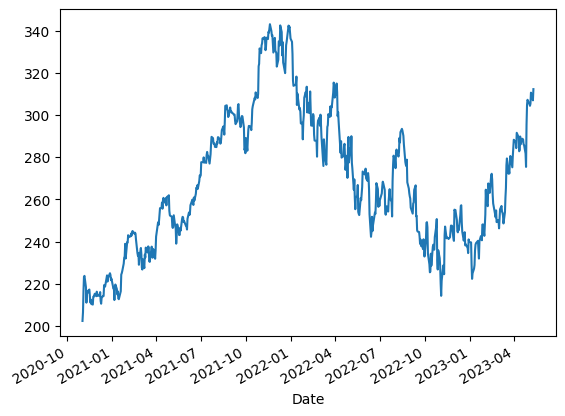

In [760]:
df_data['Close'].plot()

We generate the trading strategy base on the moving average of the stock's closing price.
Aussuming this is a long only fund, when the 5-day moving average crosses above the 20-day moving average, we buy the stock, otherwise don't hold the stock.


In [761]:
short_window = 5
long_window=20

df_data['ShortMA'] = df_data['Close'].rolling(window=short_window).mean()
df_data['LongMA'] = df_data['Close'].rolling(window=long_window).mean()


<Axes: xlabel='Date'>

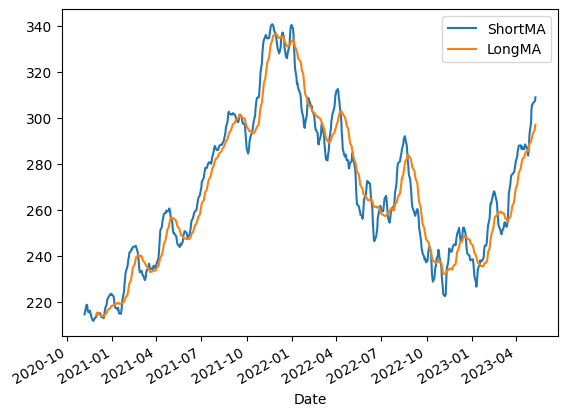

In [762]:
df_data[['ShortMA', 'LongMA']].plot()

In [763]:
tc = 0.005  # assuming the transaction cost
df_data['Return'] = df_data['Close'].pct_change()

df_data['ShortMA-1'] = df_data['ShortMA'].shift(1)
df_data['LongMA-1'] = df_data['LongMA'].shift(1)
df_data.loc[df_data["ShortMA-1"].notna() & df_data["LongMA-1"].notna() & (df_data['ShortMA'] > df_data['LongMA']) & (df_data['ShortMA-1'] < df_data['LongMA-1']), "holding"] = 1
df_data.loc[df_data["ShortMA-1"].notna() & df_data["LongMA-1"].notna() & (df_data['ShortMA'] < df_data['LongMA']) & (df_data['ShortMA-1'] > df_data['LongMA-1']), "holding"] = 0
df_data['holding'] = df_data['holding'].ffill()
df_data['holding'] = df_data['holding'].fillna(0)
df_data['holding-1'] = df_data['holding'].shift(1)



In [764]:
'''Calculate the profit and loss, sharp rqatio, and trading days'''
df_data['pnl'] = df_data['Return'] * df_data['holding-1'] - tc * abs(df_data['holding'] - df_data['holding-1'])
df_data['pnlcumu'] = df_data['pnl'].cumsum()
df_data['buyhold'] = df_data['Return'].cumsum()
sharp_ratio = df_data['pnl'].mean() / df_data['pnl'].std() * (252 ** 0.5)
trading_days = df_data['holding'].sum()


In [765]:
sharp_ratio

-0.25342579006284627

In [766]:
trading_days

355.0

In [767]:
'''Define a function to calculate the CLHL strategy performance for a given threshold and transaction cost'''
def calculate_ma(data, size, short_window=5, tc=0.0005):
    df_data = data.copy()
    long_window = short_window + size
    df_data['ShortMA'] = df_data['Close'].rolling(window=short_window).mean()
    df_data['LongMA'] = df_data['Close'].rolling(window=long_window).mean()
    df_data['ShortMA-1'] = df_data['ShortMA'].shift(1)
    df_data['LongMA-1'] = df_data['LongMA'].shift(1)

    df_data.loc[df_data["ShortMA-1"].notna() & df_data["LongMA-1"].notna() & (df_data['ShortMA'] > df_data['LongMA']) & (df_data['ShortMA-1'] < df_data['LongMA-1']), "holding"] = 1
    df_data.loc[df_data["ShortMA-1"].notna() & df_data["LongMA-1"].notna() & (df_data['ShortMA'] < df_data['LongMA']) & (df_data['ShortMA-1'] > df_data['LongMA-1']), "holding"] = 0
    df_data['holding'] = df_data['holding'].ffill()
    
    df_data['holding'] = df_data['holding'].fillna(0)
    df_data['holding-1'] = df_data['holding'].shift(1)

    df_data['Return'] = df_data['Close'].pct_change()
    df_data['pnl'] = df_data['Return'] * df_data['holding-1'] - tc * abs(df_data['holding'] - df_data['holding-1'])
    df_data['pnl_cum'] = df_data['pnl'].cumsum()
    df_data['ret_cum'] = df_data['Return'].cumsum()
    sharp_ratio = df_data['pnl'].mean() / df_data['pnl'].std() * (252 ** 0.5)
    trading_days = df_data['holding'].sum()

    return sharp_ratio, trading_days, df_data

In [768]:
'''Calcuate window difference and the corresponding sharp ratio and trading days iteratively'''
diff = [i for i in range(5, 255)]
sharp_ratios = []
trading_days = []

for size in diff:
    sharp_ratio, trading_day, df_new = calculate_ma (df_data, size)
    sharp_ratios.append(sharp_ratio)
    trading_days.append(trading_day)

In [769]:
'''Combine the window size difference , sharp ratio, trading days to dataframe'''
df_result = pd.DataFrame({'size': diff, 'sharp_ratio': sharp_ratios, 'trading_days': trading_days})

In [770]:
'''Sort the df_result by sharp_ratio'''
df_result = df_result.sort_values(by='sharp_ratio', ascending=False)

In [771]:
df_result.head()

,size,sharp_ratio,trading_days
2,7,0.458351,355.0
1,6,0.408898,356.0
178,183,0.274561,355.0
3,8,0.268896,354.0
180,185,0.258361,354.0


In [772]:
'''Pick the best window size difference'''
df_best  = calculate_ma(df_data, 7)

<Axes: title={'center': 'Moving Avg Cross over vs Buy and Hold'}, xlabel='Date', ylabel='Return'>

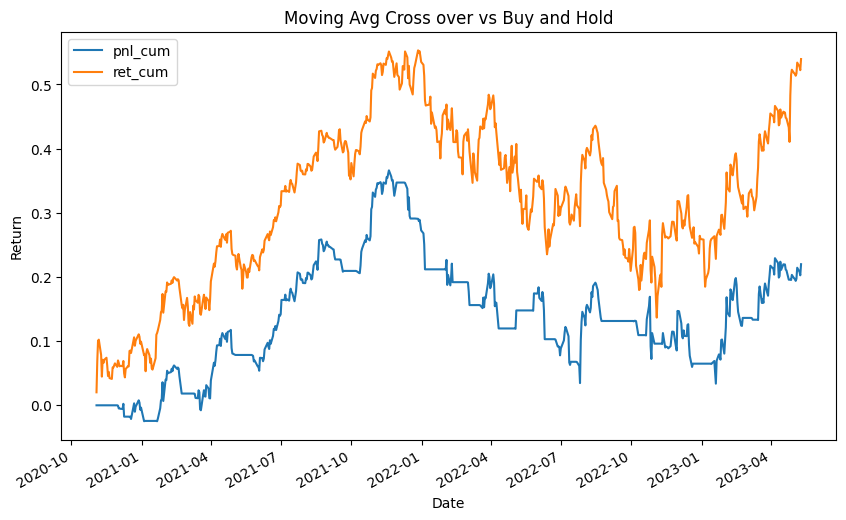

In [773]:
'''Compare the active trading return vs buy and hold return'''
df_best[2][['pnl_cum', 'ret_cum']].plot(title='Moving Avg Cross over vs Buy and Hold', ylabel="Return", xlabel='Date' ,figsize=(10, 6))


The moving average cross over strategy doesn't do better than just buy and hold.